# Performance evaluation of ML model 

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import seaborn as sns
from scipy.stats import gaussian_kde

import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from helpers import get_ytrue_y_pred_agg
from helpers import get_ytrue_y_pred_agg_season
from helpers import get_prediction_per_season_test

from model_classes import CustomXGBRegressor

#from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_season


## Helper functions

In [2]:
# Get modelled mass balance from xarray Dataset based on 
# dataframe of point mass balances
def get_modelled_mb(df, ds, type):
    """
    df : pd.DataFrame of point mb (mass balance)
    ds : xr.DataSet of modelled mass balance
    type : str, variable in ds; 'mb_annual', 'mb_summer', or 'mb_winter'
    """
    
    mb_modelled = []

    # Loop through each row of df to extract modelled mb for the given ID, year, and nearest elevation
    for row in df.itertuples(index=False):

        # Use the attributes of namedtuple
        current_year = str(row.year) + '-10-01'
        current_altitude = row.altitude
        current_id = str(row.ID)
        current_year_dt = np.datetime64(current_year)

        # Check if the current_year_dt is in the 'time' coordinate of the dataset
        if current_year_dt in ds['time'].values:

            # Find nearest elevation to point
            nearest_elevation_idx = abs(ds['elevation'] - current_altitude).argmin()
            nearest_elevation = ds['elevation'][nearest_elevation_idx]

            # Check if current_id exists in the 'ID' coordinate of the dataset
            if current_id in ds['ID'].values:

                mb_val = ds[type].sel(
                    ID=current_id, time=current_year_dt, elevation=nearest_elevation).values

                mb_val = mb_val.item()
            else:
                mb_val = np.nan
        else:
            # If modelled mb is not available for the current year, use nan
            mb_val = np.nan

        mb_modelled.append(mb_val)

    return mb_modelled


## Plotting functions

In [3]:
# Plot modelled and observed point mass balances
def plot_point_modelled(df, model, start_yr, end_yr):

    """
    df : pd.Dataframe of point mb
    type : str, variable in ds; 'netto', 'summer' or 'winter'
    model : str, model name; 'glogem', 'oggm', 'pygem'
    """

    df_clean_dropna = df.dropna(subset=['mb_'+model])

    df_clean = df_clean_dropna[(df_clean_dropna['year'] >= start_yr) & (df_clean_dropna['year'] <= end_yr)]

    y_data = df_clean['mb_'+model]
    x_data = df_clean['balance']
    
    xy = np.vstack([x_data, y_data])
    z = gaussian_kde(xy)(xy)

    df_with_density = pd.DataFrame({
        'x': x_data,
        'y': y_data,
        'z': z
        })

    df_with_density.sort_values('z', inplace=True)

    fig, ax = plt.subplots()
    scatter = ax.scatter(df_with_density['x'], df_with_density['y'], c=df_with_density['z'], s=50, cmap='viridis')

    max_val = max(x_data.max(), y_data.max())+0.5
    min_val = min(x_data.min(), y_data.min())-0.5
    
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='1:1 Line')
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xlabel('mb stake (m w.e.)')
    ax.set_ylabel('mb modelled elev band (m w.e.)')
    plt.title('Stake vs. ' + model)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_data, x_data))
    mae = mean_absolute_error(y_data, x_data) 
    r2 = r2_score(y_data, x_data) 
    count = len(x_data)  # Count the number of data points
    
    stats_text = f'Count: {count}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\n$R^2$: {r2:.2f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))
    
    #plt.legend()
    plt.colorbar(ax.collections[0], ax=ax, label='Density')
    plt.tight_layout()
    plt.grid(alpha=0.5)
    plt.show()


## Get test dataset of monthly values 

14 glaciers: [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]

- 54: 189 points
- 703: 30 points
- 941: 70 points
- 1135: 
- 1280: 71 points
- 2085: 
- 2320: 83 points
- 2478: 89 points
- 2768:
- 2769: 121 points
- 3133: 38 points
- 3137: 65 points
- 3138: 6 points
- 3141: 72 points

In [4]:
# Specify filepaths and filenames.          
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_test_svf.csv'

# Load data.
df_test_final = pd.read_csv(filepath + filename, index_col=0)

In [5]:
df_test_final

,id,BREID,RGIID,altitude,altitude_climate,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,0.778997,5,may,277.677979,4.286715e+05,-237874.5,20979516.0,0.580414,-3367191.50,0.001159
1,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,0.778997,5,jun,283.339630,-2.133166e+06,-4024573.5,17728592.0,0.198752,-3994740.00,0.003054
2,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,0.778997,5,jul,283.829285,-2.731458e+06,-5184939.5,15538729.0,0.131911,-4661453.00,0.003977
3,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,0.778997,5,aug,283.778412,-1.295387e+06,-3545874.5,10510849.0,0.130799,-4018348.50,0.004691
4,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,0.778997,5,sep,280.982513,9.352438e+03,-1756179.5,6908671.0,0.130148,-4441106.50,0.001449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24908,3091,3141,RGI60-08.02969,1078.0,917.419759,2017,-160.580241,-3.29,2.906044,0.131717,0.932281,12,may,277.690887,-5.189375e+02,-71670.0,17926120.0,0.530146,-2093793.25,0.003567
24909,3091,3141,RGI60-08.02969,1078.0,917.419759,2017,-160.580241,-3.29,2.906044,0.131717,0.932281,12,jun,280.319031,1.046328e+05,-101796.5,13385372.0,0.480811,162197.00,0.008162
24910,3091,3141,RGI60-08.02969,1078.0,917.419759,2017,-160.580241,-3.29,2.906044,0.131717,0.932281,12,jul,282.416504,-2.174798e+06,-4535185.5,15446657.0,0.183955,-3726261.25,0.007537
24911,3091,3141,RGI60-08.02969,1078.0,917.419759,2017,-160.580241,-3.29,2.906044,0.131717,0.932281,12,aug,281.939026,-1.997971e+06,-3884410.5,11212546.0,0.135438,-3417520.00,0.007390


In [6]:
# Add column for short form RGIID for retreival of model results
df_test_final['ID'] = df_test_final['RGIID'].str[-4:] # Short form of RGIID

In [7]:
df_test_final.ID = df_test_final.ID.astype(int)
df_test_final

,id,BREID,RGIID,altitude,altitude_climate,year,altitude_diff,balance,aspect,slope,...,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp,ID
0,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,...,5,may,277.677979,4.286715e+05,-237874.5,20979516.0,0.580414,-3367191.50,0.001159,1258
1,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,...,5,jun,283.339630,-2.133166e+06,-4024573.5,17728592.0,0.198752,-3994740.00,0.003054,1258
2,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,...,5,jul,283.829285,-2.731458e+06,-5184939.5,15538729.0,0.131911,-4661453.00,0.003977,1258
3,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,...,5,aug,283.778412,-1.295387e+06,-3545874.5,10510849.0,0.130799,-4018348.50,0.004691,1258
4,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,...,5,sep,280.982513,9.352438e+03,-1756179.5,6908671.0,0.130148,-4441106.50,0.001449,1258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24908,3091,3141,RGI60-08.02969,1078.0,917.419759,2017,-160.580241,-3.29,2.906044,0.131717,...,12,may,277.690887,-5.189375e+02,-71670.0,17926120.0,0.530146,-2093793.25,0.003567,2969
24909,3091,3141,RGI60-08.02969,1078.0,917.419759,2017,-160.580241,-3.29,2.906044,0.131717,...,12,jun,280.319031,1.046328e+05,-101796.5,13385372.0,0.480811,162197.00,0.008162,2969
24910,3091,3141,RGI60-08.02969,1078.0,917.419759,2017,-160.580241,-3.29,2.906044,0.131717,...,12,jul,282.416504,-2.174798e+06,-4535185.5,15446657.0,0.183955,-3726261.25,0.007537,2969
24911,3091,3141,RGI60-08.02969,1078.0,917.419759,2017,-160.580241,-3.29,2.906044,0.131717,...,12,aug,281.939026,-1.997971e+06,-3884410.5,11212546.0,0.135438,-3417520.00,0.007390,2969


### Get targets and features for ML model

In [8]:
# Select features for test
df_test_X_reduce = df_test_final.drop(['balance','year','BREID','RGIID', 'ID','altitude','altitude_climate'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_test_X = df_test_X_reduce[[c for c in df_test_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for test
df_test_y = df_test_final[['balance']]

# Get arrays of features+metadata and targets
X_test, y_test = df_test_X.values, df_test_y.values

In [9]:
df_test_X_reduce

,id,altitude_diff,aspect,slope,skyview_factor,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,-129.772081,0.629597,0.278773,0.778997,5,may,277.677979,4.286715e+05,-237874.5,20979516.0,0.580414,-3367191.50,0.001159
1,0,-129.772081,0.629597,0.278773,0.778997,5,jun,283.339630,-2.133166e+06,-4024573.5,17728592.0,0.198752,-3994740.00,0.003054
2,0,-129.772081,0.629597,0.278773,0.778997,5,jul,283.829285,-2.731458e+06,-5184939.5,15538729.0,0.131911,-4661453.00,0.003977
3,0,-129.772081,0.629597,0.278773,0.778997,5,aug,283.778412,-1.295387e+06,-3545874.5,10510849.0,0.130799,-4018348.50,0.004691
4,0,-129.772081,0.629597,0.278773,0.778997,5,sep,280.982513,9.352438e+03,-1756179.5,6908671.0,0.130148,-4441106.50,0.001449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24908,3091,-160.580241,2.906044,0.131717,0.932281,12,may,277.690887,-5.189375e+02,-71670.0,17926120.0,0.530146,-2093793.25,0.003567
24909,3091,-160.580241,2.906044,0.131717,0.932281,12,jun,280.319031,1.046328e+05,-101796.5,13385372.0,0.480811,162197.00,0.008162
24910,3091,-160.580241,2.906044,0.131717,0.932281,12,jul,282.416504,-2.174798e+06,-4535185.5,15446657.0,0.183955,-3726261.25,0.007537
24911,3091,-160.580241,2.906044,0.131717,0.932281,12,aug,281.939026,-1.997971e+06,-3884410.5,11212546.0,0.135438,-3417520.00,0.007390


### Get dataframes of annual, summer and winter mass balances for comparison

In [10]:
df_test_final

,id,BREID,RGIID,altitude,altitude_climate,year,altitude_diff,balance,aspect,slope,...,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp,ID
0,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,...,5,may,277.677979,4.286715e+05,-237874.5,20979516.0,0.580414,-3367191.50,0.001159,1258
1,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,...,5,jun,283.339630,-2.133166e+06,-4024573.5,17728592.0,0.198752,-3994740.00,0.003054,1258
2,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,...,5,jul,283.829285,-2.731458e+06,-5184939.5,15538729.0,0.131911,-4661453.00,0.003977,1258
3,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,...,5,aug,283.778412,-1.295387e+06,-3545874.5,10510849.0,0.130799,-4018348.50,0.004691,1258
4,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,...,5,sep,280.982513,9.352438e+03,-1756179.5,6908671.0,0.130148,-4441106.50,0.001449,1258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24908,3091,3141,RGI60-08.02969,1078.0,917.419759,2017,-160.580241,-3.29,2.906044,0.131717,...,12,may,277.690887,-5.189375e+02,-71670.0,17926120.0,0.530146,-2093793.25,0.003567,2969
24909,3091,3141,RGI60-08.02969,1078.0,917.419759,2017,-160.580241,-3.29,2.906044,0.131717,...,12,jun,280.319031,1.046328e+05,-101796.5,13385372.0,0.480811,162197.00,0.008162,2969
24910,3091,3141,RGI60-08.02969,1078.0,917.419759,2017,-160.580241,-3.29,2.906044,0.131717,...,12,jul,282.416504,-2.174798e+06,-4535185.5,15446657.0,0.183955,-3726261.25,0.007537,2969
24911,3091,3141,RGI60-08.02969,1078.0,917.419759,2017,-160.580241,-3.29,2.906044,0.131717,...,12,aug,281.939026,-1.997971e+06,-3884410.5,11212546.0,0.135438,-3417520.00,0.007390,2969


In [11]:
df_test_annual = df_test_final[df_test_final['n_months']==12]
df_test_annual = df_test_annual.groupby(by=['id']).mean() 
df_test_annual

C:\Users\kasj\AppData\Local\Temp\ipykernel_24420\4077999050.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test_annual = df_test_annual.groupby(by=['id']).mean()


,BREID,altitude,altitude_climate,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID
id,,,,,,,,,,,,,,,,,,
2027,54.0,471.0,341.227919,2013.0,-129.772081,-4.92,0.629597,0.278773,0.778997,12.0,273.045766,-10104.210938,-1.192698e+06,8.000492e+06,0.534814,-2.960371e+06,0.003176,1258.0
2028,54.0,439.0,341.227919,2014.0,-97.772081,-2.67,0.585924,0.296590,0.798494,12.0,272.938726,225771.765625,-8.952235e+05,7.755540e+06,0.585304,-2.756938e+06,0.003372,1258.0
2029,54.0,444.0,341.227919,2015.0,-102.772081,-3.41,0.663261,0.302508,0.803510,12.0,272.849403,133388.494792,-9.804107e+05,7.343682e+06,0.556681,-2.772570e+06,0.003141,1258.0
2030,54.0,444.0,341.227919,2016.0,-102.772081,-3.59,0.663261,0.302508,0.803510,12.0,273.300074,-14896.781250,-1.064662e+06,7.145984e+06,0.540813,-2.628417e+06,0.003110,1258.0
2031,54.0,468.0,341.227919,2017.0,-126.772081,-2.46,0.836757,0.309196,0.817480,12.0,272.918989,279420.552083,-7.474015e+05,7.817598e+06,0.538918,-2.767568e+06,0.003548,1258.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3087,3141.0,1078.0,917.419759,2012.0,-160.580241,-2.07,2.906044,0.131717,0.932281,12.0,274.500407,-340938.494792,-8.186743e+05,8.780470e+06,0.547067,-2.065823e+06,0.008703,2969.0
3088,3141.0,1078.0,917.419759,2013.0,-160.580241,-3.15,2.906044,0.131717,0.932281,12.0,272.949669,-419158.447917,-1.114851e+06,9.078827e+06,0.541262,-2.491021e+06,0.006297,2969.0
3089,3141.0,1079.0,917.419759,2015.0,-161.580241,-2.61,2.906044,0.131717,0.932281,12.0,274.638379,-144798.453125,-6.082808e+05,8.741161e+06,0.560521,-1.893852e+06,0.009249,2969.0


In [12]:
df_test_winter = df_test_final[df_test_final['n_months']==7]
df_test_winter = df_test_winter.groupby(by=['id']).mean() 
df_test_winter

C:\Users\kasj\AppData\Local\Temp\ipykernel_24420\3206729110.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test_winter = df_test_winter.groupby(by=['id']).mean()


,BREID,altitude,altitude_climate,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID
id,,,,,,,,,,,,,,,,,,
1028,54.0,471.0,341.227919,2013.0,-129.772081,1.32,0.629597,0.278773,0.778997,7.0,266.705911,800105.232143,62438.500000,3.477078e+06,0.749392,-2.148801e+06,0.003397,1258.0
1029,54.0,439.0,341.227919,2014.0,-97.772081,1.68,0.585924,0.296590,0.798494,7.0,267.740727,996367.901786,65465.714286,3.052352e+06,0.758143,-2.145037e+06,0.003847,1258.0
1030,54.0,444.0,341.227919,2015.0,-102.772081,0.76,0.663261,0.302508,0.803510,7.0,267.579795,946459.196429,21334.214286,3.186665e+06,0.750785,-2.258321e+06,0.002979,1258.0
1031,54.0,444.0,341.227919,2016.0,-102.772081,0.78,0.663261,0.302508,0.803510,7.0,267.811977,868039.937500,102229.642857,3.540237e+06,0.771447,-2.084224e+06,0.003243,1258.0
1032,54.0,468.0,341.227919,2017.0,-126.772081,1.59,0.836757,0.309196,0.817480,7.0,268.226903,856574.433036,64772.571429,3.494867e+06,0.679859,-2.391737e+06,0.003806,1258.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022,3141.0,1078.0,917.419759,2012.0,-160.580241,1.50,2.906044,0.131717,0.932281,7.0,270.836827,23270.491071,-171713.642857,4.804682e+06,0.683440,-1.769234e+06,0.010046,2969.0
2023,3141.0,1078.0,917.419759,2013.0,-160.580241,1.14,2.906044,0.131717,0.932281,7.0,267.233730,125356.500000,-123023.142857,5.492646e+06,0.711911,-2.165743e+06,0.006262,2969.0
2024,3141.0,1079.0,917.419759,2015.0,-161.580241,1.19,2.906044,0.131717,0.932281,7.0,271.190260,-7447.285714,-271647.642857,4.664342e+06,0.653273,-1.837262e+06,0.011195,2969.0


In [13]:
df_test_summer = df_test_final[df_test_final['n_months']==5]
df_test_summer = df_test_summer.groupby(by=['id']).mean() 
df_test_summer

C:\Users\kasj\AppData\Local\Temp\ipykernel_24420\1147432955.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test_summer = df_test_summer.groupby(by=['id']).mean()


,BREID,altitude,altitude_climate,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID
id,,,,,,,,,,,,,,,,,,
0,54.0,471.0,341.227919,2013.0,-129.772081,-6.24,0.629597,0.278773,0.778997,5.0,281.921564,-1.144397e+06,-2949888.30,14333271.4,0.234405,-4096567.90,0.002866,1258.0
1,54.0,439.0,341.227919,2014.0,-97.772081,-4.35,0.585924,0.296590,0.798494,5.0,280.215924,-8.530628e+05,-2240188.45,14340004.3,0.343329,-3613599.05,0.002707,1258.0
2,54.0,444.0,341.227919,2015.0,-102.772081,-4.17,0.663261,0.302508,0.803510,5.0,280.226855,-1.004910e+06,-2382853.60,13163506.1,0.284936,-3492518.15,0.003367,1258.0
3,54.0,444.0,341.227919,2016.0,-102.772081,-4.37,0.663261,0.302508,0.803510,5.0,280.983411,-1.251008e+06,-2698309.70,12194028.9,0.217927,-3390287.60,0.002925,1258.0
4,54.0,468.0,341.227919,2017.0,-126.772081,-4.05,0.836757,0.309196,0.817480,5.0,279.487909,-5.285949e+05,-1884445.15,13869421.1,0.341601,-3293730.55,0.003186,1258.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,3141.0,1078.0,917.419759,2012.0,-160.580241,-3.57,2.906044,0.131717,0.932281,5.0,279.629419,-8.508311e+05,-1724419.25,14346574.6,0.356145,-2481046.90,0.006822,2969.0
1024,3141.0,1078.0,917.419759,2013.0,-160.580241,-4.29,2.906044,0.131717,0.932281,5.0,280.951984,-1.181479e+06,-2503409.00,14099480.7,0.302352,-2946410.05,0.006346,2969.0
1025,3141.0,1079.0,917.419759,2015.0,-161.580241,-3.80,2.906044,0.131717,0.932281,5.0,279.465747,-3.370901e+05,-1079567.30,14448706.6,0.430668,-1973078.45,0.006524,2969.0


In [14]:
df_test_annual.reset_index(drop=True, inplace=True)
df_test_winter.reset_index(drop=True, inplace=True)
df_test_summer.reset_index(drop=True, inplace=True)

df_test_annual.ID = df_test_annual.ID.astype(np.int64)
df_test_winter.ID = df_test_winter.ID.astype(np.int64)
df_test_summer.ID = df_test_summer.ID.astype(np.int64)
df_test_annual['ID'] = df_test_annual['ID'].astype(str).str.zfill(4).str[-4:]
df_test_winter['ID'] = df_test_winter['ID'].astype(str).str.zfill(4).str[-4:]
df_test_summer['ID'] = df_test_summer['ID'].astype(str).str.zfill(4).str[-4:]

df_test_annual.year = df_test_annual.year.astype(np.int64)
df_test_winter.year = df_test_winter.year.astype(np.int64)
df_test_summer.year = df_test_summer.year.astype(np.int64)

In [15]:
print(df_test_annual.dtypes)


BREID               float64
altitude            float64
altitude_climate    float64
year                  int64
altitude_diff       float64
balance             float64
aspect              float64
slope               float64
skyview_factor      float64
n_months            float64
t2m                 float64
sshf                float64
slhf                float64
ssrd                float64
fal                 float64
str                 float64
tp                  float64
ID                   object
dtype: object


## Get ML-model predictions

In [147]:
# Model trained on cluster using up to 0.2 for learning rate. 
# Learning rate [0.01, 0.1, 0.2]
# Max depth [2, 4, 6]
# n_estimators [50, 100, 200, 300]
#with open('Training_cluster/2024-07-10_20-37-03/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using extended grid search (after implementing custom loss funciton performance improvement)
# param_ranges = {'max_depth': [4, 5, 6, 7, 8], # Depth of tree
#                'n_estimators': [200, 300, 400, 500, 600, 700], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.1, 0.15, 0.2, 0.25], #[0,1]
#with open('Training_cluster/2024-08-06_12-07-32/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ALL ANNUAL, SUMMER, WINTER DATA
with open('Training_cluster/2024-10-24_10-30-28/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ALL ANNUAL AND WINTER DATA
#with open('Training_cluster/2024-10-25_09-45-30/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)


best_model = clf_loaded.best_estimator_
#best_model = CustomXGBRegressor(max_depth=5, learning_rate=0.05, n_estimators=200, gamma=0, random_state=23, min_child_weight=0)
#best_model.fit(X_train, y_train)

In [148]:
best_model

CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.05,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=5, max_leaves=None,
                   min_child_weight=0, missing=nan, monotone_constraints=None,
                   multi_strategy=None, n_estimators=300, n_jobs=None,
                   num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000002B0126F4820>, ...)

C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


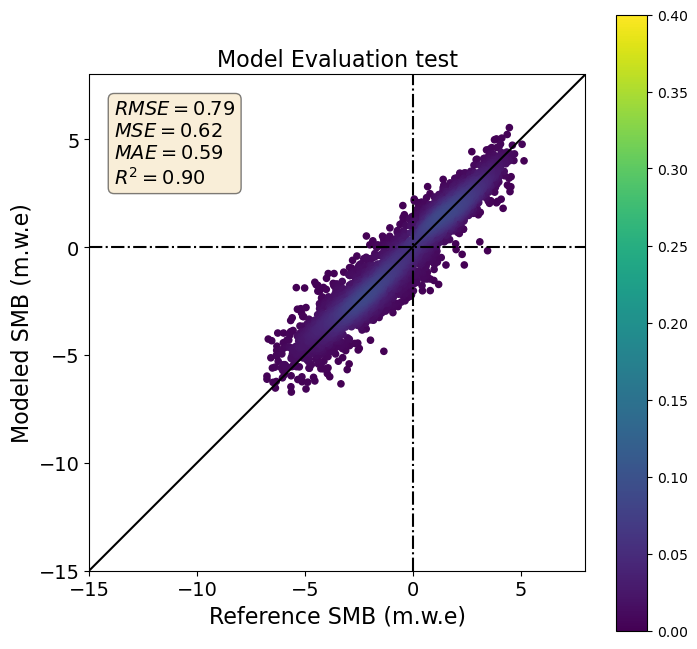

In [149]:
test_pred = best_model.predict(X_test)

# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

In [150]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)

df_test_winter['mb_ML'] = y_pred_winter_agg

In [151]:
df_test_winter

,BREID,altitude,altitude_climate,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID,mb_ML
0,54.0,471.0,341.227919,2013,-129.772081,1.32,0.629597,0.278773,0.778997,7.0,266.705911,800105.232143,62438.500000,3.477078e+06,0.749392,-2.148801e+06,0.003397,1258,1.444547
1,54.0,439.0,341.227919,2014,-97.772081,1.68,0.585924,0.296590,0.798494,7.0,267.740727,996367.901786,65465.714286,3.052352e+06,0.758143,-2.145037e+06,0.003847,1258,1.899905
2,54.0,444.0,341.227919,2015,-102.772081,0.76,0.663261,0.302508,0.803510,7.0,267.579795,946459.196429,21334.214286,3.186665e+06,0.750785,-2.258321e+06,0.002979,1258,1.364813
3,54.0,444.0,341.227919,2016,-102.772081,0.78,0.663261,0.302508,0.803510,7.0,267.811977,868039.937500,102229.642857,3.540237e+06,0.771447,-2.084224e+06,0.003243,1258,1.783165
4,54.0,468.0,341.227919,2017,-126.772081,1.59,0.836757,0.309196,0.817480,7.0,268.226903,856574.433036,64772.571429,3.494867e+06,0.679859,-2.391737e+06,0.003806,1258,1.843004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,3141.0,1078.0,917.419759,2012,-160.580241,1.50,2.906044,0.131717,0.932281,7.0,270.836827,23270.491071,-171713.642857,4.804682e+06,0.683440,-1.769234e+06,0.010046,2969,2.120444
995,3141.0,1078.0,917.419759,2013,-160.580241,1.14,2.906044,0.131717,0.932281,7.0,267.233730,125356.500000,-123023.142857,5.492646e+06,0.711911,-2.165743e+06,0.006262,2969,1.299575
996,3141.0,1079.0,917.419759,2015,-161.580241,1.19,2.906044,0.131717,0.932281,7.0,271.190260,-7447.285714,-271647.642857,4.664342e+06,0.653273,-1.837262e+06,0.011195,2969,2.329732
997,3141.0,1078.0,917.419759,2016,-160.580241,1.72,2.906044,0.131717,0.932281,7.0,270.403787,18733.339286,-251040.928571,5.058185e+06,0.655849,-1.987646e+06,0.009280,2969,1.805306


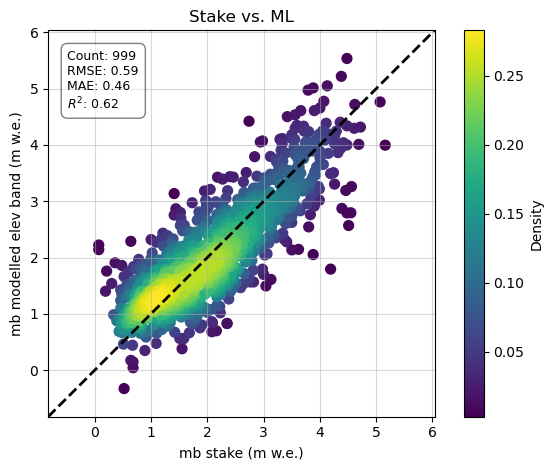

In [152]:
plot_point_modelled(df_test_winter, 'ML', 1959, 2022)

In [153]:
df_test_summer

,BREID,altitude,altitude_climate,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID
0,54.0,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,0.778997,5.0,281.921564,-1.144397e+06,-2949888.30,14333271.4,0.234405,-4096567.90,0.002866,1258
1,54.0,439.0,341.227919,2014,-97.772081,-4.35,0.585924,0.296590,0.798494,5.0,280.215924,-8.530628e+05,-2240188.45,14340004.3,0.343329,-3613599.05,0.002707,1258
2,54.0,444.0,341.227919,2015,-102.772081,-4.17,0.663261,0.302508,0.803510,5.0,280.226855,-1.004910e+06,-2382853.60,13163506.1,0.284936,-3492518.15,0.003367,1258
3,54.0,444.0,341.227919,2016,-102.772081,-4.37,0.663261,0.302508,0.803510,5.0,280.983411,-1.251008e+06,-2698309.70,12194028.9,0.217927,-3390287.60,0.002925,1258
4,54.0,468.0,341.227919,2017,-126.772081,-4.05,0.836757,0.309196,0.817480,5.0,279.487909,-5.285949e+05,-1884445.15,13869421.1,0.341601,-3293730.55,0.003186,1258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,3141.0,1078.0,917.419759,2012,-160.580241,-3.57,2.906044,0.131717,0.932281,5.0,279.629419,-8.508311e+05,-1724419.25,14346574.6,0.356145,-2481046.90,0.006822,2969
1024,3141.0,1078.0,917.419759,2013,-160.580241,-4.29,2.906044,0.131717,0.932281,5.0,280.951984,-1.181479e+06,-2503409.00,14099480.7,0.302352,-2946410.05,0.006346,2969
1025,3141.0,1079.0,917.419759,2015,-161.580241,-3.80,2.906044,0.131717,0.932281,5.0,279.465747,-3.370901e+05,-1079567.30,14448706.6,0.430668,-1973078.45,0.006524,2969
1026,3141.0,1078.0,917.419759,2016,-160.580241,-4.38,2.906044,0.131717,0.932281,5.0,281.836530,-9.977858e+05,-2213228.25,13748145.0,0.285253,-2613071.80,0.007863,2969


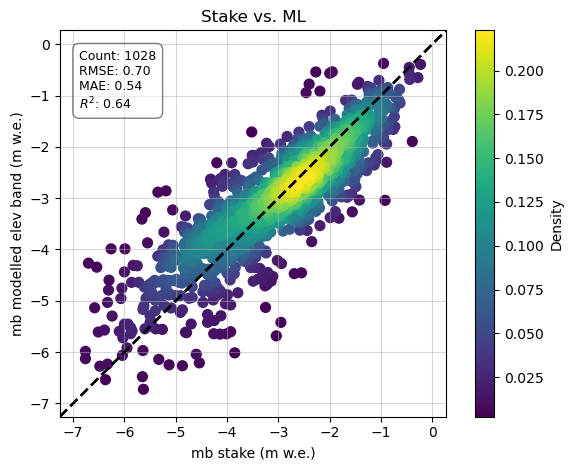

In [154]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)

df_test_summer['mb_ML'] = y_pred_summer_agg
plot_point_modelled(df_test_summer, 'ML', 1959, 2022)

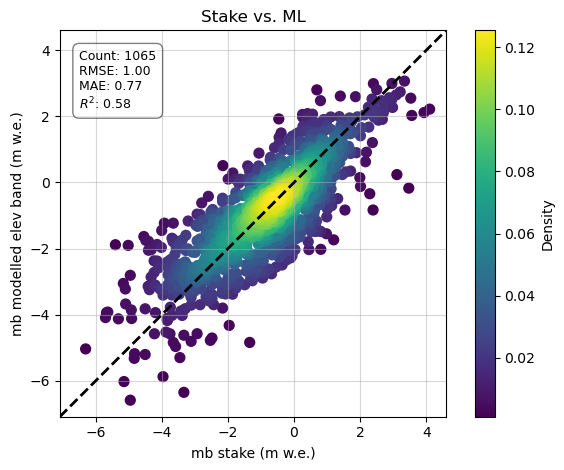

In [155]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)

df_test_annual['mb_ML'] = y_pred_annual_agg
plot_point_modelled(df_test_annual, 'ML', 1959, 2022)

## Plot modelled point mass balance against observed point mass balance for all models

In [156]:
# PLOT POINTS WITH GAUSSIAN KDE (WORKS ONLY FOR COMMON TIME PERIOD DUE TO SORTING)
# Three dataframes that only contain predictions for test glaciers:
# df_test_annual
# df_test_winter
# df_test_summer

# Each df contains the following columns: 
# year, balance, mb_glogem, mb_oggm, mb_pygem, mb_ML

# Set the start and end years for the filter
start_year = 1960#1979
end_year = 2021#2019

gl = 'all'

# Function to filter DataFrame based on year range
def filter_df_by_year(df, start_year, end_year):
    return df[(df['year'] >= start_year) & (df['year'] <= end_year)]

# Filter the DataFrames
#df_obs_nonan = df_obs.dropna(subset=['RGIID'])
if gl == 'test':
    print('test')
    #df_obs_nonan = filter_df_by_rgiid_and_year(df_obs_nonan, test_glaciers, start_year, end_year)
    #df_pred_filtered = filter_df_by_rgiid_and_year(df_pred, test_glaciers, start_year, end_year)
    #df_oggm_filtered = filter_df_by_rgiid_and_year(df_oggm, test_glaciers, start_year, end_year)
    #df_glogem_filtered = filter_df_by_rgiid_and_year(df_glogem, test_glaciers, start_year, end_year)
    #df_pygem_filtered = filter_df_by_rgiid_and_year(df_pygem, test_glaciers, start_year, end_year)
elif gl == 'all':
    df_annual_filtered = filter_df_by_year(df_test_annual, start_year, end_year)
    df_winter_filtered = filter_df_by_year(df_test_winter, start_year, end_year)
    df_summer_filtered = filter_df_by_year(df_test_summer, start_year, end_year)

# List of model columns and corresponding labels
models = [('mb_ML', 'XGBoost')]

#models = [('mb_ML', 'Mass Balance Machine'), ('mb_oggm', 'OGGM'), ('mb_glogem', 'GloGEM'), ('mb_pygem', 'PyGEM')]

def remove_nan_rows(df, model_cols):
    """Remove rows with NaNs in the 'balance' column or any of the model columns."""
    columns_to_check = ['balance'] + model_cols
    return df.dropna(subset=columns_to_check)



In [157]:
# List of model columns
model_cols = ['mb_ML']
#model_cols = ['mb_ML', 'mb_oggm', 'mb_glogem', 'mb_pygem']

# Filter DataFrames to remove rows with NaNs in relevant columns
df_annual_filtered = remove_nan_rows(df_annual_filtered, model_cols)
df_winter_filtered = remove_nan_rows(df_winter_filtered, model_cols)
df_summer_filtered = remove_nan_rows(df_summer_filtered, model_cols)


In [158]:
# Step 1: Add a 'Type' Column to Each DataFrame
df_annual_filtered['Type'] = 'Ba'
df_winter_filtered['Type'] = 'Bw'
df_summer_filtered['Type'] = 'Bs'

# Step 2: Concatenate the DataFrames into One
combined_df = pd.concat([df_annual_filtered, df_winter_filtered, df_summer_filtered], ignore_index=True)

# Calculate the point density
def gaussian_kde_plot(x_,y_):
    xy = np.vstack([x_,y_])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x_[idx], y_[idx], z[idx]
    return x, y, z

from matplotlib.colors import ListedColormap
my_cmap_blue = sns.dark_palette('tab:blue', n_colors=8, as_cmap=True, reverse=True)
my_cmap_red = sns.dark_palette('tab:red', n_colors=8, as_cmap=True, reverse=True)
my_cmap_black = sns.dark_palette('grey', n_colors=8, as_cmap=True, reverse=True)
my_alpha = 0.5

cm=1/2.54
fontsize = 8
fontsize_small = 8.0
fontsize_min = 8.0
markersize = 20
subplot_labels = ['(a)', '(b)', '(c)', '(d)']

In [159]:
combined_df

,BREID,altitude,altitude_climate,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID,mb_ML,Type
0,54.0,471.0,341.227919,2013,-129.772081,-4.92,0.629597,0.278773,0.778997,12.0,273.045766,-1.010421e+04,-1.192698e+06,8.000492e+06,0.534814,-2.960371e+06,0.003176,1258,-3.853414,Ba
1,54.0,439.0,341.227919,2014,-97.772081,-2.67,0.585924,0.296590,0.798494,12.0,272.938726,2.257718e+05,-8.952235e+05,7.755540e+06,0.585304,-2.756938e+06,0.003372,1258,-2.807321,Ba
2,54.0,444.0,341.227919,2015,-102.772081,-3.41,0.663261,0.302508,0.803510,12.0,272.849403,1.333885e+05,-9.804107e+05,7.343682e+06,0.556681,-2.772570e+06,0.003141,1258,-2.633042,Ba
3,54.0,444.0,341.227919,2016,-102.772081,-3.59,0.663261,0.302508,0.803510,12.0,273.300074,-1.489678e+04,-1.064662e+06,7.145984e+06,0.540813,-2.628417e+06,0.003110,1258,-2.602581,Ba
4,54.0,468.0,341.227919,2017,-126.772081,-2.46,0.836757,0.309196,0.817480,12.0,272.918989,2.794206e+05,-7.474015e+05,7.817598e+06,0.538918,-2.767568e+06,0.003548,1258,-2.444545,Ba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3087,3141.0,1078.0,917.419759,2012,-160.580241,-3.57,2.906044,0.131717,0.932281,5.0,279.629419,-8.508311e+05,-1.724419e+06,1.434657e+07,0.356145,-2.481047e+06,0.006822,2969,-3.808799,Bs
3088,3141.0,1078.0,917.419759,2013,-160.580241,-4.29,2.906044,0.131717,0.932281,5.0,280.951984,-1.181479e+06,-2.503409e+06,1.409948e+07,0.302352,-2.946410e+06,0.006346,2969,-4.611671,Bs
3089,3141.0,1079.0,917.419759,2015,-161.580241,-3.80,2.906044,0.131717,0.932281,5.0,279.465747,-3.370901e+05,-1.079567e+06,1.444871e+07,0.430668,-1.973078e+06,0.006524,2969,-3.424848,Bs
3090,3141.0,1078.0,917.419759,2016,-160.580241,-4.38,2.906044,0.131717,0.932281,5.0,281.836530,-9.977858e+05,-2.213228e+06,1.374814e+07,0.285253,-2.613072e+06,0.007863,2969,-5.268450,Bs


## Temporal bias

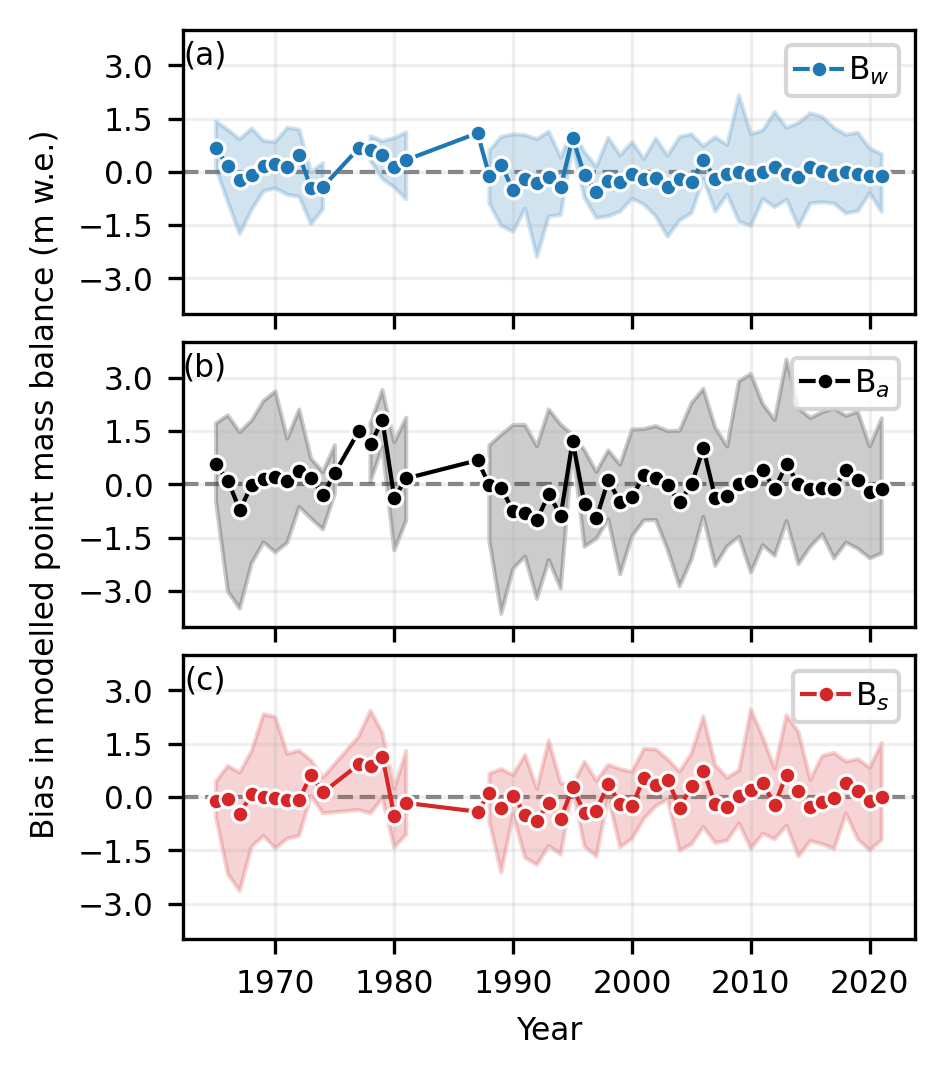

In [160]:
# Plot temporal bias in modelled point mass balance (whole time series)

df = combined_df.copy()

#df['residual'] = df['balance'] - df['mb_ML']

# A positive residual indicates that the modeled value is greater than the observed value.
# A negative residual indicates that the modeled value is less than the observed value.
df['residual'] = df['mb_ML'] - df['balance']

type_colors = {'Ba': 'black', 'Bs': 'C3', 'Bw': 'C0'}

cm=1/2.54
fontsize = 7.5

fig, axes = plt.subplots(3, 1, figsize=(8*cm, 10*cm), dpi=300, sharex=True, sharey=True)

# Order the Types: Bw, Ba, Bs
types_order = ['Bw', 'Ba', 'Bs']
annotations = ['(a)', '(b)', '(c)']

for ax, t_type, annotation in zip(axes, types_order, annotations):
    df_type = df[df['Type'] == t_type]
    
    line = sns.lineplot(x='year', y='residual', data=df_type, marker='o', 
                        label=t_type[-2]+'$_{'+t_type[-1]+'}$', ax=ax, 
                        errorbar=("pi", 100), # Show full spread
                        linewidth = 1, color=type_colors[t_type])

    for line_obj in ax.get_lines():
        line_obj.set_markersize(4)
    
    ax.axhline(0, color='gray', linestyle='--', lw=1, zorder=0)
    ax.set_ylim(-4, 4)
    ax.set_yticks([-3, -1.5, 0, 1.5, 3])
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_ylabel('')

    ax.grid(alpha=0.2)
    ax.legend(fontsize=fontsize, handletextpad = 0.2, handlelength=1.5, borderpad=0.3)

    ax.annotate(annotation, xy=(0.03, 0.91), xycoords='axes fraction', fontsize=fontsize,
                ha='center', va='center')

axes[-2].set_ylabel('Bias in modelled point mass balance (m w.e.)', fontsize = fontsize)
axes[-1].set_xlabel('Year', fontsize=fontsize)

plt.subplots_adjust(hspace=0.1)

#pdf_path = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Projects/2022_ML_for_MB_Norway/Figures_paper/'
#plt.savefig(pdf_path+'temporal_bias_point_test.pdf', format='pdf', bbox_inches='tight')

plt.show()

## Point metrics

In [161]:
# Calculate RMSE, MSE, and bias

metrics = {}
labels = ['Mass Balance Machine', 'OGGM', 'GloGEM', 'PyGEM']

print('Metrics based on period :')
print(str(start_year))
print(str(end_year))

for idx, model in enumerate(model_cols):
    label = labels[idx]

    metrics[label] = {}

    for metric in ['Ba', 'Bw', 'Bs']:
        modeled = combined_df[combined_df['Type']==metric][model].values
        observed = combined_df[combined_df['Type']==metric]['balance'].values 
        rmse = root_mean_squared_error(observed, modeled)
        mse = mean_squared_error(observed, modeled)
        mae = np.mean(abs(modeled - observed))
        bias = np.mean(modeled - observed)
        r2 = r2_score(observed, modeled) 
        count = len(observed)  # Count valid pairs
        
        metrics[label][metric] = {'rmse': rmse, 'mse': mse, 'mae': mae, 'bias': bias, 'r2':r2, 'count': count}

        print(f'{label} - {metric}: RMSE={rmse:.2f}, MSE={mse:.2f}, MAE={mae:.2f}, Bias={bias:.2f}, R²={r2:.2f}, Count={count}')

Metrics based on period :
1960
2021
Mass Balance Machine - Ba: RMSE=1.00, MSE=0.99, MAE=0.77, Bias=-0.01, R²=0.64, Count=1065
Mass Balance Machine - Bw: RMSE=0.59, MSE=0.35, MAE=0.46, Bias=-0.01, R²=0.66, Count=999
Mass Balance Machine - Bs: RMSE=0.70, MSE=0.49, MAE=0.54, Bias=0.04, R²=0.72, Count=1028


In [162]:
metrics

{'Mass Balance Machine': {'Ba': {'rmse': 0.9962432349868108,
   'mse': 0.992500583256986,
   'mae': 0.77048958293762,
   'bias': -0.012342778009064314,
   'r2': 0.6350928531077868,
   'count': 1065},
  'Bw': {'rmse': 0.5881431236293185,
   'mse': 0.34591233387245185,
   'mae': 0.46349981519600775,
   'bias': -0.012205676384993636,
   'r2': 0.6632686953241367,
   'count': 999},
  'Bs': {'rmse': 0.7000514540616427,
   'mse': 0.49007203833382024,
   'mae': 0.5384146910602017,
   'bias': 0.036053360255079964,
   'r2': 0.7192517507562985,
   'count': 1028}}}

## Point performance XGBoost Model per glacier

C:\Users\kasj\AppData\Local\Temp\ipykernel_11160\528339522.py:101: MatplotlibDeprecationWarning: The remove function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().remove(ax)  # Disable shared x-axis
C:\Users\kasj\AppData\Local\Temp\ipykernel_11160\528339522.py:105: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax, axs[0])  # Re-enable shared x-axis if needed


Plot index 11: Setting xticks and xticklabels.


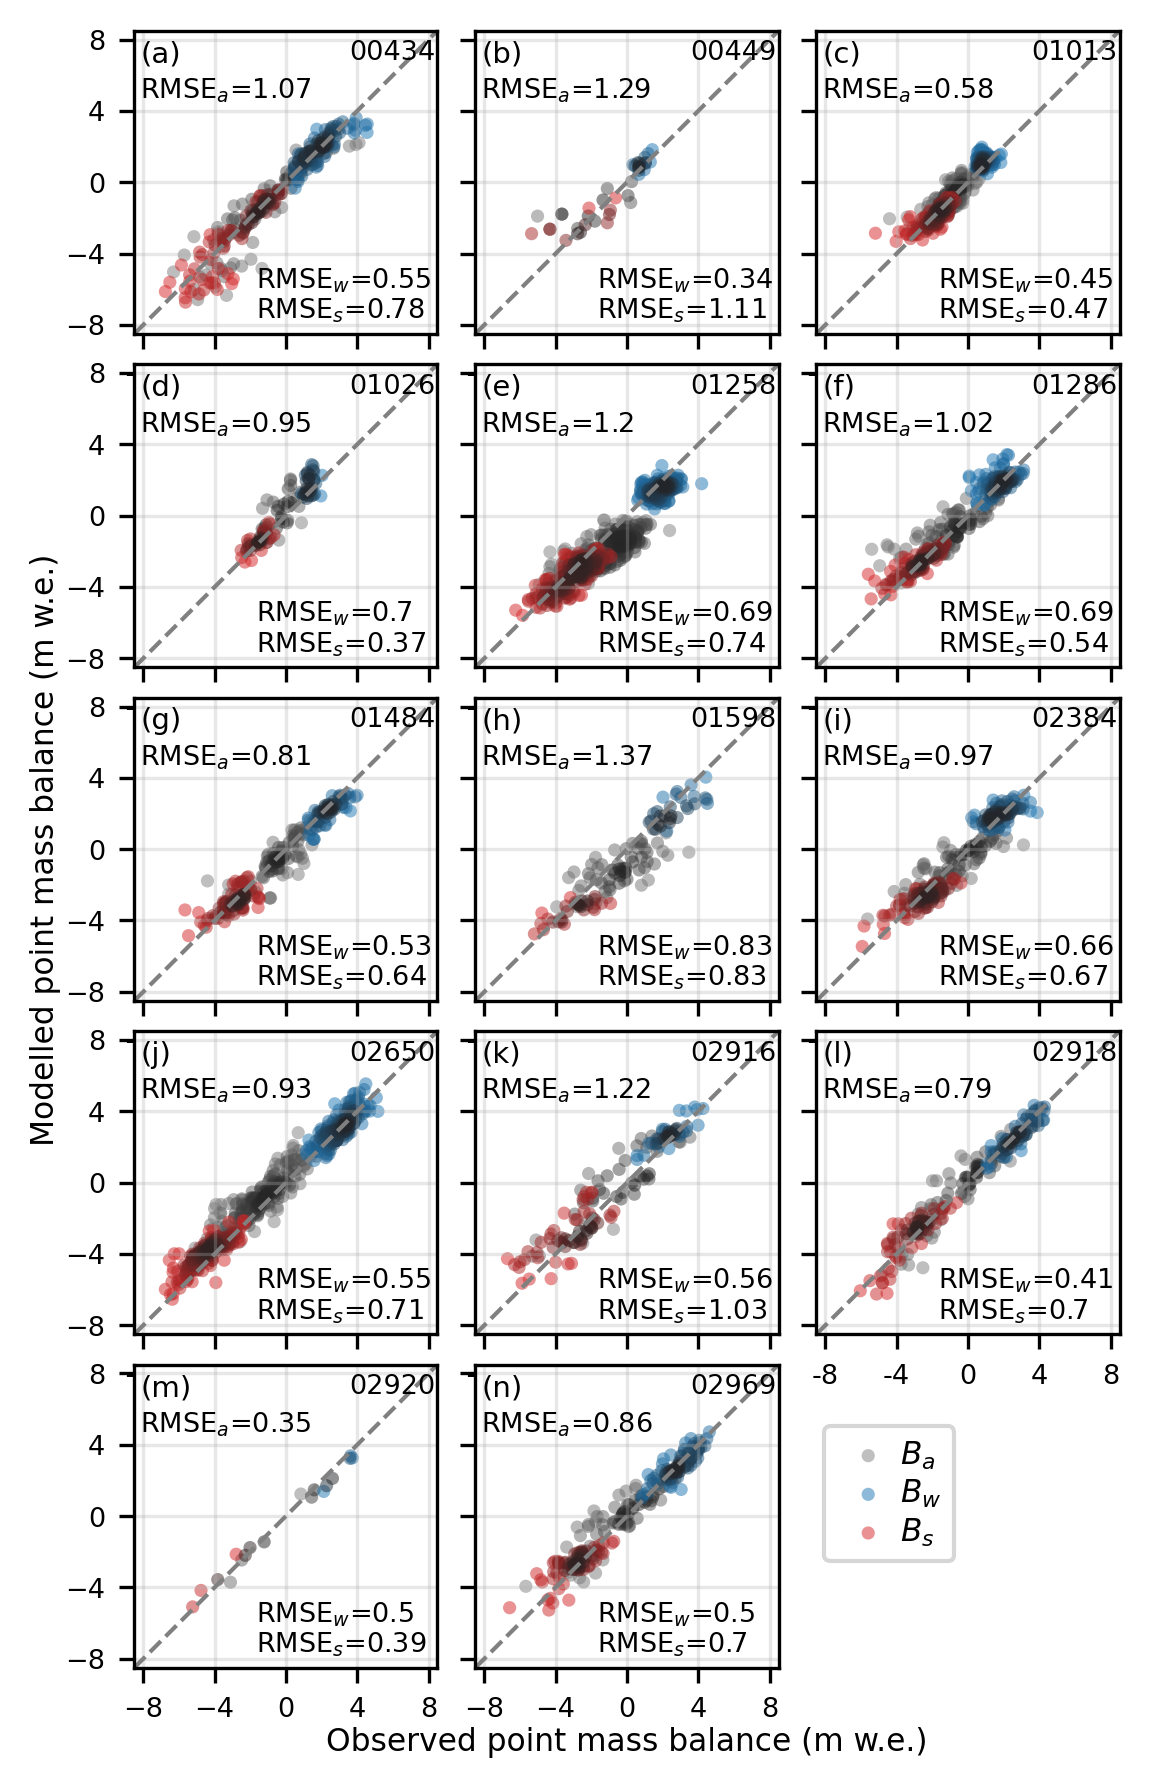

In [163]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Function to calculate the point density
def gaussian_kde_plot(x_, y_):
    xy = np.vstack([x_, y_])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    return x_[idx], y_[idx], z[idx]

# Custom colormaps
from matplotlib.colors import ListedColormap
my_cmap_blue = sns.dark_palette('tab:blue', n_colors=8, as_cmap=True, reverse=True)
my_cmap_red = sns.dark_palette('tab:red', n_colors=8, as_cmap=True, reverse=True)
my_cmap_black = sns.dark_palette('grey', n_colors=8, as_cmap=True, reverse=True)
my_alpha = 0.5

# Plot parameters
cm = 1/2.54
fontsize = 7
fontsize_small = 6.5
markersize = 10
subplot_labels = ['(a)', '(b)', '(c)', '(d)']

# Placeholder for the data; you should define combined_df accordingly
# combined_df = ...
# Order test glaciers
test_glaciers = ['0434', '0449', '1013', '1026', '1258', '1286', '1484', '1598', '2384', '2650', '2916', '2918', '2920', '2969']
combined_df_ordered = combined_df[combined_df['ID'].isin(test_glaciers)]
combined_df_ordered['ID'] = pd.Categorical(combined_df_ordered['ID'], categories=test_glaciers, ordered=True)
combined_df_ordered = combined_df_ordered.sort_values('ID')

# Helper Function to Calculate RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Set figure and subplots
fig, axs = plt.subplots(5, 3, figsize=(11 * cm, 18 * cm), sharey=True, dpi=300)
axs = axs.flatten()

# Common properties
tick_min = -8
tick_max = 8
ticks = np.arange(tick_min, tick_max + 1, 4)
model_cols = ['mb_ML']
labels = ['Mass Balance Machine']
glaciers = list(combined_df_ordered.ID.unique())
breid = list(combined_df_ordered.BREID.unique())
n = 14  # Number of glaciers to plot

# Placeholder for metrics; you should define metrics accordingly
# metrics = ...

# Loop through the glaciers
plot_index = 0
for i, glacier in enumerate(glaciers[:n]):
    df_glacier = combined_df_ordered[combined_df_ordered['ID'] == glacier]
    ax = axs[plot_index]

    for idx, model in enumerate(model_cols):
        label = labels[idx]

        for metric in ['Ba', 'Bw', 'Bs']:
            y_ = df_glacier[df_glacier['Type'] == metric][model].values
            x_ = df_glacier[df_glacier['Type'] == metric]['balance'].values
            x, y, z = gaussian_kde_plot(x_, y_)

            if metric == 'Ba':
                ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_black, alpha=my_alpha, label=metric)
                rmse = root_mean_squared_error(x_, y_)
                rmse_txt = "RMSE$_{a}$=" + str(round(rmse, 2))
                ax.annotate(rmse_txt, xy=(0.02, 0.85), xycoords='axes fraction', fontsize=6.5, va='top')
            elif metric == 'Bw':
                ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_blue, alpha=my_alpha, label=metric)
                rmse = root_mean_squared_error(x_, y_)
                rmse_txt = "RMSE$_{w}$=" + str(round(rmse, 2))
                ax.annotate(rmse_txt, xy=(0.4, 0.13), xycoords='axes fraction', fontsize=6.5, va='bottom', ha='left')
            elif metric == 'Bs':
                ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_red, alpha=my_alpha, label=metric)
                rmse = root_mean_squared_error(x_, y_)
                rmse_txt = "RMSE$_{s}$=" + str(round(rmse, 2))
                ax.annotate(rmse_txt, xy=(0.4, 0.03), xycoords='axes fraction', fontsize=6.5, va='bottom', ha='left')

    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', color='gray', linewidth=1)
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-8.5, 8.5)
    ax.set_ylim(-8.5, 8.5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_small)
    ax.annotate(f'({chr(97 + plot_index)})', xy=(0.02, 0.97), xycoords='axes fraction', fontsize=7, ha='left', va='top')
    ax.annotate(f'0{glacier}', xy=(0.85, 0.97), xycoords='axes fraction', fontsize=6.5, ha='center', va='top')
    ax.legend().remove()  # Remove individual legends for efficiency

    if plot_index == 11:
        orig_share_x = ax.get_shared_x_axes()
        ax.get_shared_x_axes().remove(ax)  # Disable shared x-axis
        ax.set_xticks(ticks)
        ax.set_xticklabels([-8, -4, 0, 4, 8])
        print(f"Plot index {plot_index}: Setting xticks and xticklabels.")  # Debugging: Verify plot_index 11 is reached
        ax.get_shared_x_axes().join(ax, axs[0])  # Re-enable shared x-axis if needed

    plot_index += 1

# Turn off any extra empty subplots
for ax in axs[plot_index:]:
    ax.axis('off')

# Main legend and labels
axs[plot_index - 1].legend(['$B_{a}$','$B_{w}$','$B_{s}$'], frameon=True, loc='lower left', fontsize=7.5, ncol=1, 
               handlelength=2, handletextpad=0.02, borderaxespad=0.5, borderpad=0.4, labelspacing=0.2, 
               columnspacing=0.8, bbox_to_anchor=(1.1, 0.3))

axs[6].set_ylabel('Modelled point mass balance (m w.e.)', fontsize=7.5, labelpad=1)
axs[13].set_xlabel('Observed point mass balance (m w.e.)', fontsize=7.5, labelpad=1)

plt.subplots_adjust(wspace=0.05, hspace=0.1)

# Uncomment to save the figure
# plt.savefig('path_to_save_plot.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [164]:
combined_df


,BREID,altitude,altitude_climate,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID,mb_ML,Type
0,54.0,471.0,341.227919,2013,-129.772081,-4.92,0.629597,0.278773,0.778997,12.0,273.045766,-1.010421e+04,-1.192698e+06,8.000492e+06,0.534814,-2.960371e+06,0.003176,1258,-3.853414,Ba
1,54.0,439.0,341.227919,2014,-97.772081,-2.67,0.585924,0.296590,0.798494,12.0,272.938726,2.257718e+05,-8.952235e+05,7.755540e+06,0.585304,-2.756938e+06,0.003372,1258,-2.807321,Ba
2,54.0,444.0,341.227919,2015,-102.772081,-3.41,0.663261,0.302508,0.803510,12.0,272.849403,1.333885e+05,-9.804107e+05,7.343682e+06,0.556681,-2.772570e+06,0.003141,1258,-2.633042,Ba
3,54.0,444.0,341.227919,2016,-102.772081,-3.59,0.663261,0.302508,0.803510,12.0,273.300074,-1.489678e+04,-1.064662e+06,7.145984e+06,0.540813,-2.628417e+06,0.003110,1258,-2.602581,Ba
4,54.0,468.0,341.227919,2017,-126.772081,-2.46,0.836757,0.309196,0.817480,12.0,272.918989,2.794206e+05,-7.474015e+05,7.817598e+06,0.538918,-2.767568e+06,0.003548,1258,-2.444545,Ba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3087,3141.0,1078.0,917.419759,2012,-160.580241,-3.57,2.906044,0.131717,0.932281,5.0,279.629419,-8.508311e+05,-1.724419e+06,1.434657e+07,0.356145,-2.481047e+06,0.006822,2969,-3.808799,Bs
3088,3141.0,1078.0,917.419759,2013,-160.580241,-4.29,2.906044,0.131717,0.932281,5.0,280.951984,-1.181479e+06,-2.503409e+06,1.409948e+07,0.302352,-2.946410e+06,0.006346,2969,-4.611671,Bs
3089,3141.0,1079.0,917.419759,2015,-161.580241,-3.80,2.906044,0.131717,0.932281,5.0,279.465747,-3.370901e+05,-1.079567e+06,1.444871e+07,0.430668,-1.973078e+06,0.006524,2969,-3.424848,Bs
3090,3141.0,1078.0,917.419759,2016,-160.580241,-4.38,2.906044,0.131717,0.932281,5.0,281.836530,-9.977858e+05,-2.213228e+06,1.374814e+07,0.285253,-2.613072e+06,0.007863,2969,-5.268450,Bs


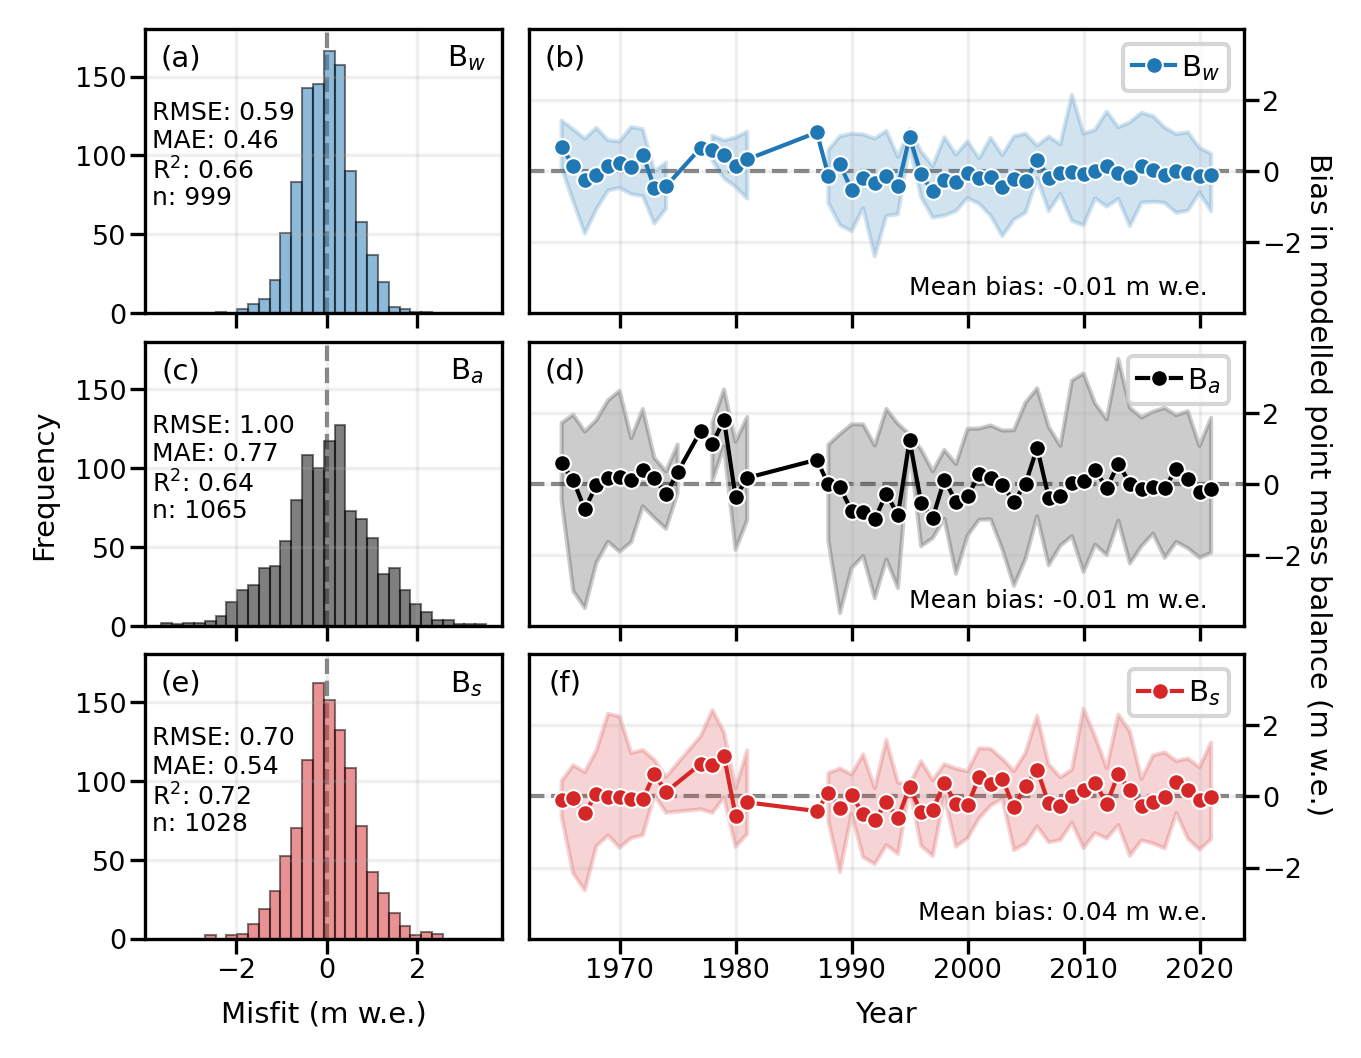

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming combined_df is your DataFrame
df = combined_df.copy()

# Step 1: Calculate residuals
df['residual'] = df['mb_ML'] - df['balance']

# Define colors and other parameters
type_colors = {'Ba': 'black', 'Bs': 'C3', 'Bw': 'C0'}
cm = 1/2.54
fontsize = 7.0

# Create the figure and GridSpec
fig = plt.figure(figsize=(12*cm, 10*cm), dpi=300)
gs = fig.add_gridspec(3, 2, width_ratios=[1, 2], hspace=0.1)

# Order the Types: Bw, Ba, Bs
types_order = ['Bw', 'Ba', 'Bs']
annotations1 = ['(a)', '(c)', '(e)']
annotations2 = ['(b)', '(d)', '(f)']
types_labels = ['B$_w$', 'B$_a$', 'B$_s$']


# Loop through each type
for idx, t_type in enumerate(types_order):
    df_type = df[df['Type'] == t_type]
    
    # Histogram plot for residuals (now in the first column)
    ax_hist = fig.add_subplot(gs[idx, 0])
    bins = np.histogram_bin_edges(df['residual'], bins=30)  # Ensure consistent bin width
    ax_hist.hist(df_type['residual'], bins=bins, color=type_colors[t_type], alpha=0.5, edgecolor='black', linewidth=0.5)
    ax_hist.grid(alpha=0.2)

    # Move the y-axis label and ticks to the left
    ax_hist.yaxis.set_ticks_position('left')
    ax_hist.yaxis.set_label_position('left')
    #ax_hist.set_ylabel('Frequency', fontsize=fontsize)
    ax_hist.set_xlabel('Misfit (m w.e.)', fontsize=fontsize)
    ax_hist.tick_params(axis='both', which='major', labelsize=fontsize)

    # Manually set y-axis limits and ticks on the first column
    ax_hist.set_ylim(0, 180)  # Adjust y-limit as per your data range
    ax_hist.set_yticks([0, 50, 100, 150])

    # Add annotation to the histogram
    ax_hist.annotate(annotations1[idx], xy=(0.1, 0.90), 
                     xycoords='axes fraction', fontsize=fontsize,
                     ha='center', va='center')

    # Time series plot for residuals (now in the second column)
    ax_ts = fig.add_subplot(gs[idx, 1])
    sns.lineplot(x='year', y='residual', 
                 data=df_type, marker='o', 
                 label=t_type[-2]+'$_{'+t_type[-1]+'}$', 
                 ax=ax_ts, errorbar=("pi", 100), 
                 linewidth=1, color=type_colors[t_type],
                markeredgewidth=0.5)#, markersize=5)
    
    for line_obj in ax_ts.get_lines():
        line_obj.set_markersize(4)
    
    ax_ts.axhline(0, color='gray', linestyle='--', lw=1, zorder=0)
    ax_ts.set_ylim(-4, 4)
    ax_ts.set_yticks([-2, 0, 2])
    ax_ts.tick_params(axis='both', which='major', labelsize=6.5, pad=1)
    ax_ts.set_ylabel('')

    ax_hist.axvline(0, color='gray', linestyle='--', lw=1, zorder=0)
    ax_hist.tick_params(axis='both', which='major', labelsize=6.5, pad=1)


    ax_ts.grid(alpha=0.2)
    ax_ts.legend(fontsize=fontsize, handletextpad=0.2, handlelength=1.5, borderpad=0.3)

    ax_ts.annotate(annotations2[idx], xy=(0.05, 0.90), 
                   xycoords='axes fraction', fontsize=fontsize,
                   ha='center', va='center')

    ax_hist.annotate(types_labels[idx], xy=(0.90, 0.90), 
                   xycoords='axes fraction', fontsize=fontsize,
                   ha='center', va='center')

    # Move the y-axis label and ticks to the right
    ax_ts.yaxis.set_ticks_position('right')
    ax_ts.yaxis.set_label_position('right')

    if idx ==0:
        ax_ts.set_xticklabels([])
        ax_hist.set_xticklabels([])

    
    if idx == 1:
        ax_ts.set_ylabel('Bias in modelled point mass balance (m w.e.)', fontsize=fontsize, rotation=270, labelpad=7)
        ax_hist.set_ylabel('Frequency', fontsize=fontsize)
        ax_ts.set_xticklabels([])
        ax_hist.set_xticklabels([])


    if idx == 2:
        ax_ts.set_xlabel('Year', fontsize=fontsize)

    # Add bias annotation
    bias_value = metrics['Mass Balance Machine'][t_type]['bias']
    rmse_value = metrics['Mass Balance Machine'][t_type]['rmse']
    mae_value = metrics['Mass Balance Machine'][t_type]['mae']
    r2_value = metrics['Mass Balance Machine'][t_type]['r2']
    count_value = metrics['Mass Balance Machine'][t_type]['count']


    ax_ts.annotate(f'Mean bias: {bias_value:.2f} m w.e.', xy=(0.95, 0.05), 
                   xycoords='axes fraction', fontsize=6, 
                   ha='right', va='bottom', color='black')

    ax_hist.annotate(f'RMSE: {rmse_value:.2f}', xy=(0.02, 0.75), 
                   xycoords='axes fraction', fontsize=6, 
                   ha='left', va='top', color='black')

    ax_hist.annotate(f'MAE: {mae_value:.2f}', xy=(0.02, 0.65), 
                   xycoords='axes fraction', fontsize=6, 
                   ha='left', va='top', color='black')
    
    ax_hist.annotate(f'R$^2$: {r2_value:.2f}', xy=(0.02, 0.55), 
                   xycoords='axes fraction', fontsize=6, 
                   ha='left', va='top', color='black')

    ax_hist.annotate(f'n: {count_value:.0f}', xy=(0.02, 0.45), 
                   xycoords='axes fraction', fontsize=6, 
                   ha='left', va='top', color='black')

plt.subplots_adjust(wspace=0.05, hspace=0.03)

#pdf_path = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Projects/2022_ML_for_MB_Norway/Figures_paper/'
#plt.savefig(pdf_path+'performance_point_test.pdf', format='pdf', bbox_inches='tight')

plt.show()
